In [1]:
!pip install pytorch_lightning


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from pathlib import Path
import torch
import librosa
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
import pickle
import random
import gc
import os
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.tuner import Tuner
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR


from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config & Helper functions

In [3]:
class Audio_Config:
    sr = 44100
    n_fft = 1024
    hop_length = 500
    n_mels = 128
    fmin= 20
    fmax = 4000
    power = 2.0

In [5]:
def seed_set(SEED = 42):    
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True
    print(f'Seed set at {SEED}')

def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        

In [18]:
class Config:
    def __init__(self, config_dir_path, weights_dir_path):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.batch_size = 8
        self.epochs = 10
        self.global_epoch = 0
        self.lr = 1e-3
        self.config_dir_path = Path(config_dir_path)
        self.weights_dir_path = Path(weights_dir_path)
        
    def __reduce__(self):
        return (self.__class__, (self.config_dir_path, self.weights_dir_path))
    
    def save(self):
        save_path = self.config_dir_path / 'config.pkl'
        with open(save_path, 'wb') as file:
            pickle.dump(self, file)
        
        
    @staticmethod
    def load(dir_path):
        load_path = Path(dir_path) / 'config.pkl'
        with open(load_path, 'rb') as file:
            config = pickle.load(file)
        return config
        
    


In [19]:
audio_config = Audio_Config()
config = Config('configuration', 'weights')

# Convert Audio to Melspectograms

In [8]:
google_data_path = Path('Audio_data')
kaggle_data_path = Path('Snoring Dataset')
mel_dir_path = Path('mel_data')


In [9]:
data_paths = list(google_data_path.rglob('*.mp3'))
print(len(data_paths))
data_paths.extend(list(kaggle_data_path.rglob('*.wav')))

3093


In [26]:
rows = []
for path in data_paths:
    y, sr = librosa.load(path)
    
    name, idx = path.stem.split('_')

    
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=audio_config.sr, n_fft=audio_config.n_fft,
        hop_length=audio_config.n_mels, fmin=audio_config.fmin, fmax=audio_config.fmax, power = audio_config.power
    )
    
    mel_spec = mel_spec.astype('float32')
    mel_spec_db = librosa.power_to_db(mel_spec)

    
    
    if name in ('1', '0'):
        name = 'snoring' if name == '1' else 'non-snoring'
    
    
    mel_path = mel_dir_path / f'{name}_{idx}'
    np.save(mel_path, mel_spec_db)
        
    if name.lower() in ('snoring', 'snore'):
        label = 1
    else:
        label = 0
        
    row = [mel_path.name, label]
    rows.append(row)
    

columns = ['file_name', 'label']

df = pd.DataFrame(rows, columns=columns)

print(df.head())


c:\Python312\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


   file_name  label
0    cough_1      0
1   cough_10      0
2  cough_100      0
3  cough_101      0
4  cough_102      0


In [13]:
print(df['label'].value_counts())

label
1    2318
0    1775
Name: count, dtype: int64


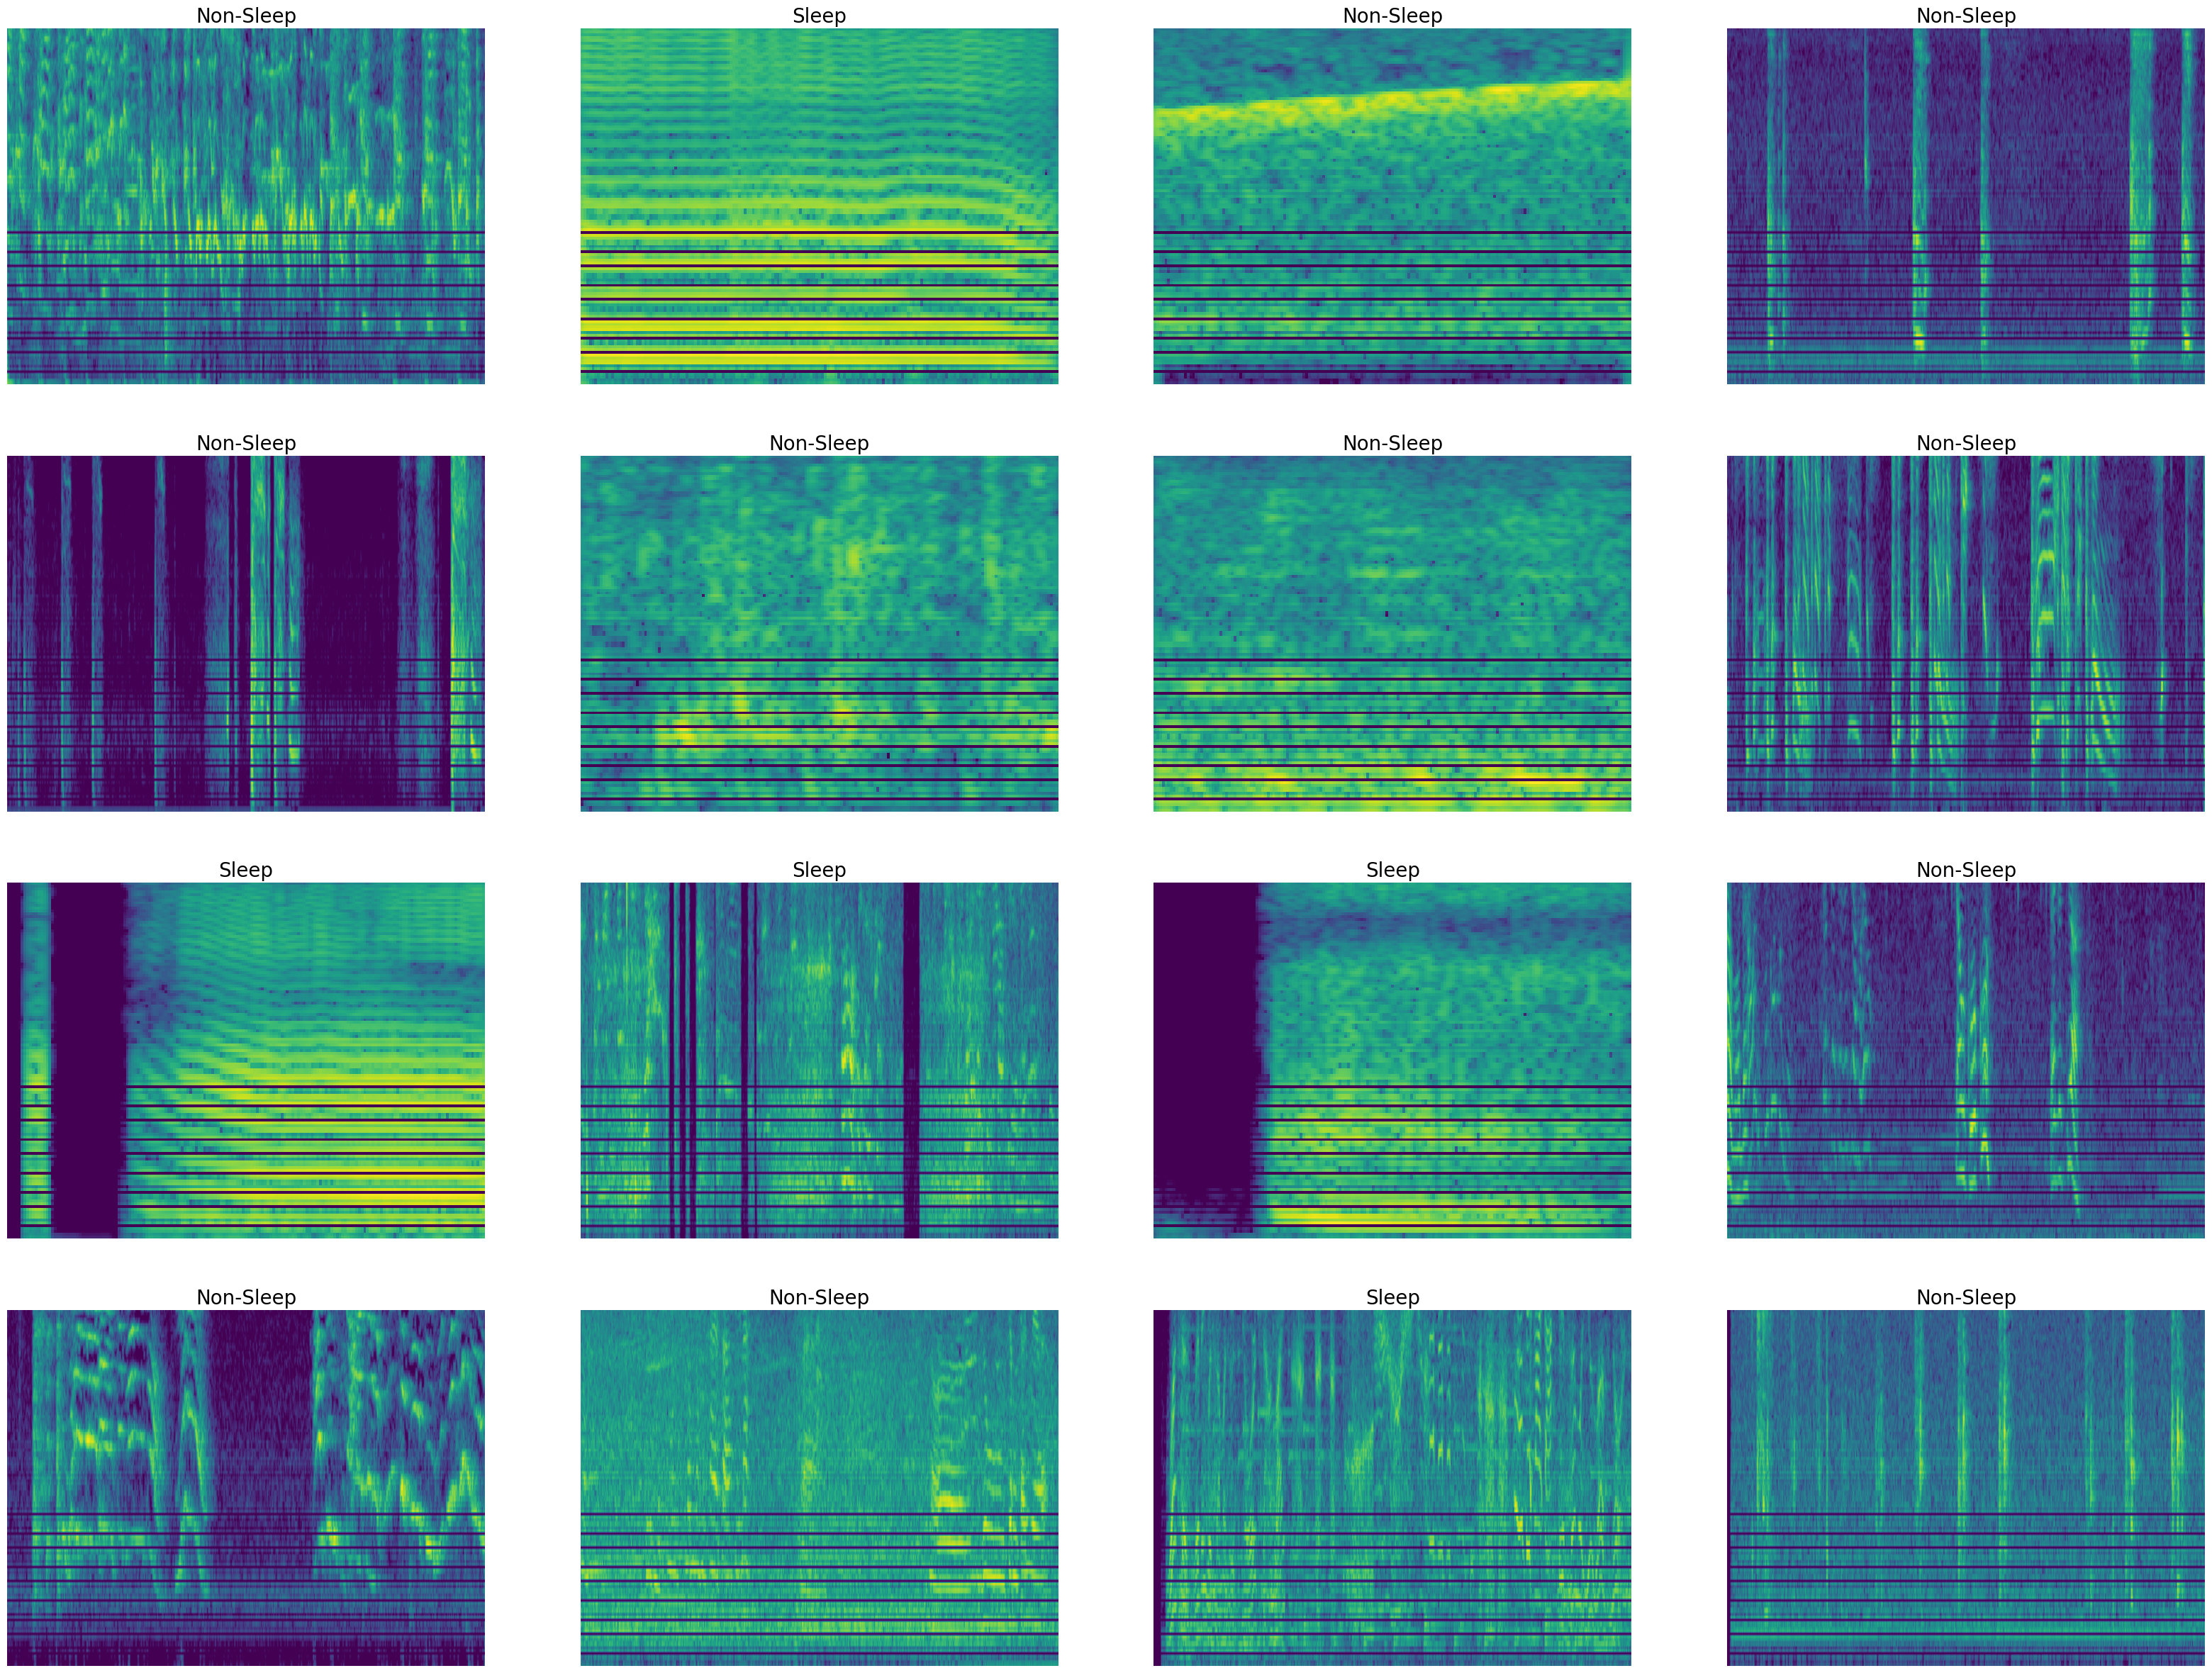

In [14]:
def visualize_melspectograms(df, n_samples, ncols = 4):
    
    nrows = ceil(n_samples / ncols) 
    
    samples = df.sample(n=n_samples)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(40, 30))
    axes = axes.flatten()
    
    for  i, (_, row) in enumerate(samples.iterrows()):                
        np_path = mel_dir_path / f'{row['file_name']}.npy'
        label = 'Sleep' if row['label'] == 1 else 'Non-Sleep'
        image_array = np.load(np_path)
        
        axes[i].imshow(image_array, aspect='auto', origin='lower')
        axes[i].set_title(label, fontsize=20)
        axes[i].axis('off')
        
    for i in range(n_samples, len(axes)):
        axes[i].set_visible(False)
        

visualize_melspectograms(df, n_samples=16)
    
    
    

# Building Dataset

In [15]:
class SleepDataset(Dataset):
    def __init__(self, df, transforms, mel_dir_path):
        super().__init__()
        self.df = df
        self.transforms = transforms
        self.mel_dir_path = Path(mel_dir_path)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        np_path = self.mel_dir_path / f"{row['file_name']}.npy"
        image_array = np.load(np_path)
        img_array = np.stack((image_array, image_array, image_array), axis=-1)
        
        label = torch.tensor(row['label'], dtype=torch.long)
        image = self.transforms(img_array)
        return image, label

In [27]:
def load_dataloaders(df, p = 0.8):
    
    # Can add other transfomrs in the future
    basic_transforms = v2.Compose([
        v2.ToImage(),
        v2.Resize((512, 512)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    split = int(len(df) * p)
    train_df = df[:split]
    val_df = df[split:]
    
    train_dataset = SleepDataset(train_df, basic_transforms, mel_dir_path)
    val_dataset = SleepDataset(val_df, basic_transforms, mel_dir_path)
    
    train_dataloder = DataLoader(dataset=train_dataset, batch_size=config.batch_size, num_workers=0,  pin_memory=True, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=config.batch_size, num_workers=0,  pin_memory=True, shuffle=False)
    
    return train_dataloder, val_dataloader
    
train_dataloader, val_dataloader = get_dataloaders(df)

# Model 

In [22]:
class EfficientNetLitModel(pl.LightningModule):
    def __init__(self, num_classes):
        super(EfficientNetLitModel, self).__init__()
        self.model = efficientnet_v2_s(EfficientNet_V2_S_Weights.DEFAULT)
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_ftrs, num_classes)    
        self.lr = 1e-3

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        x, y = batch
        x, y = x.to(config.device), y.to(config.device)
        y_hat = self(x)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


## Find Optimal learning rate

Seed set at 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr:  91%|█████████ | 91/100 [00:25<00:02,  3.54it/s]
`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 91 steps due to diverging loss.
Learning rate set to 0.0022908676527677745
Restoring states from the checkpoint path at c:\Users\pphar\Documents\SUDS2024\.lr_find_13e49fb1-dd59-4537-b963-4f9f64081c77.ckpt
Restored all states from the checkpoint at c:\Users\pphar\Documents\SUDS2024\.lr_find_13e49fb1-dd59-4537-b963-4f9f64081c77.ckpt
C:\Users\pphar\AppData\Local\Temp\ipykernel_20288\3202652525.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


0.0022908676527677745


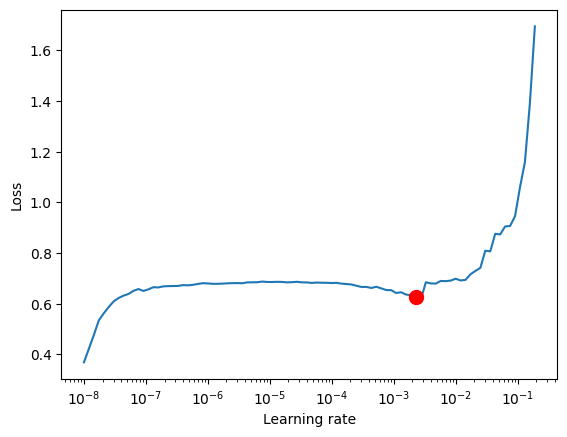

In [22]:

seed_set()
flush()

# Step 3: Use the learning rate finder
model = EfficientNetLitModel(num_classes=2).to(config.device)
trainer = Trainer(max_epochs=1)
tuner = Tuner(trainer)


# Run learning rate finder
lr_finder = tuner.lr_find(model, train_dataloaders=train_dataloader)

# Plot learning rate
fig = lr_finder.plot(suggest=True)
fig.show()

# Get suggested learning rate
new_lr = lr_finder.suggestion()
print(new_lr)
config.lr = new_lr


In [23]:
config.save()

## Training

In [1]:
import torch
from tqdm import tqdm

def training_and_validation(model, loss_fn, optimizer, scheduler, train_dataloader, val_dataloader, config, load=False):
    best_loss = float('inf')
    device = config.device
    
    best_model_path = config.weights_dir_path / 'best_model.pth'
    
    if load and best_model_path.exists():
        model.load_state_dict(torch.load(best_model_path))
    
    for epoch in range(config.epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        train_batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {config.global_epoch + 1} [Train]")
        
        for X, y in train_batch_iterator:
            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, prediction = torch.max(y_pred, 1)
            correct_train += (prediction == y).sum().item()
            total_train += y.size(0)
            
            train_batch_iterator.set_postfix(batch_loss=loss.item())

        train_loss /= len(train_dataloader)
        train_accuracy = correct_train / total_train * 100
        
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_batch_iterator = tqdm(val_dataloader, desc=f"Processing Epoch {config.global_epoch + 1} [Validation]")
        
        with torch.no_grad():
            for X, y in val_batch_iterator:
                X, y = X.to(device), y.to(device)
                
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
                
                _, prediction = torch.max(y_pred, 1)
                correct_val += (prediction == y).sum().item()
                total_val += y.size(0)
                
                val_batch_iterator.set_postfix(batch_loss=loss.item())
                
        val_loss /= len(val_dataloader)
        val_accuracy = correct_val / total_val * 100
        
        print(f"Epoch {config.global_epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
        epoch_model_path = config.weights_dir_path / f'model_epoch_{config.global_epoch + 1:02d}.pth'
        torch.save(model.state_dict(), epoch_model_path)
        config.global_epoch += 1
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        scheduler.step()  
        
        config.save()


In [30]:

config = Config.load(dir_path='configuration')
config.batch_size = 8

model = EfficientNetLitModel(num_classes=2).to(config.device)
train_dataloader, val_dataloader = load_dataloaders(df)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


training_and_validation(model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, 
                        train_dataloader=train_dataloader, val_dataloader=val_dataloader, config=config)

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Processing Epoch 1 [Validation]: 100%|██████████| 103/103 [00:17<00:00,  5.75it/s, batch_loss=0.151] 


Epoch 1: Train Loss: 0.4747, Train Accuracy: 78.19%, Validation Loss: 0.9375, Validation Accuracy: 66.06%


c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Processing Epoch 2 [Validation]: 100%|██████████| 103/103 [00:15<00:00,  6.53it/s, batch_loss=0.371]


Epoch 2: Train Loss: 0.4131, Train Accuracy: 81.80%, Validation Loss: 0.4770, Validation Accuracy: 75.95%


Processing Epoch 3 [Validation]: 100%|██████████| 103/103 [00:14<00:00,  7.22it/s, batch_loss=0.0368]


Epoch 3: Train Loss: 0.3525, Train Accuracy: 85.16%, Validation Loss: 0.6721, Validation Accuracy: 70.33%


Processing Epoch 4 [Validation]: 100%|██████████| 103/103 [00:14<00:00,  7.15it/s, batch_loss=0.0246]


Epoch 4: Train Loss: 0.3419, Train Accuracy: 85.98%, Validation Loss: 0.5701, Validation Accuracy: 79.00%


Processing Epoch 5 [Validation]: 100%|██████████| 103/103 [00:14<00:00,  7.20it/s, batch_loss=0.79] 


Epoch 5: Train Loss: 0.3013, Train Accuracy: 87.72%, Validation Loss: 0.4493, Validation Accuracy: 76.19%


Processing Epoch 6 [Validation]: 100%|██████████| 103/103 [00:16<00:00,  6.15it/s, batch_loss=0.0209] 


Epoch 6: Train Loss: 0.3180, Train Accuracy: 87.39%, Validation Loss: 0.3932, Validation Accuracy: 80.59%


Processing Epoch 7 [Validation]: 100%|██████████| 103/103 [00:14<00:00,  6.88it/s, batch_loss=0.00337]


Epoch 7: Train Loss: 0.2999, Train Accuracy: 87.57%, Validation Loss: 0.6683, Validation Accuracy: 79.24%


Processing Epoch 8 [Validation]: 100%|██████████| 103/103 [00:15<00:00,  6.67it/s, batch_loss=0.00301]


Epoch 8: Train Loss: 0.2704, Train Accuracy: 89.55%, Validation Loss: 0.2862, Validation Accuracy: 88.89%


Processing Epoch 9 [Validation]: 100%|██████████| 103/103 [00:15<00:00,  6.65it/s, batch_loss=0.0265]


Epoch 9: Train Loss: 0.2621, Train Accuracy: 90.01%, Validation Loss: 0.6320, Validation Accuracy: 78.27%


Processing Epoch 10 [Validation]: 100%|██████████| 103/103 [00:16<00:00,  6.09it/s, batch_loss=0.0295] 


Epoch 10: Train Loss: 0.2363, Train Accuracy: 90.47%, Validation Loss: 0.3012, Validation Accuracy: 87.06%
